# Stand-Up Comedy Topic Modeling Across Cultures
## Natural Language Processing (E1282) Research Note, Dr. Sascha Göbel
- Author: Lonny Chen (216697)
- Submission Date: 7 January 2026
### Contents
TODO section links

In [1]:
# Local environment
import sys
sys.path.append('../../')
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from data.data_collection import get_channels_shorts_video_ids, get_transcript_from_video_id
from data.data_preprocessing import find_annotations, custom_preprocessor_transcripts, vectorize_transcripts_to_bow
from data.data_preprocessing import custom_tokenizer_spacy0, custom_tokenizer_spacy1, custom_tokenizer_spacy_lemma
from data.data_plotting import plot_transcript_len, create_token_frequency, plot_zipf
from ldia_model.ldia_model import fit_ldia_model, create_df_topic_words_list
from ldia_model.ldia_model_plotting import print_topic_words, plot_topic_words, print_dominant_topics

## Data Collection
### Step 1: Get YouTube video IDs
- Use of [YT-DLP](https://github.com/yt-dlp/yt-dlp) for extracting video information is referenced from [StandUp4AI](https://github.com/Standup4AI/dataset/) project code.

In [3]:
%%time
# Input YouTube channel search information here
channels = [
    {
        'channel': 'Comedy Central Stand-Up',
        'search_url': 'https://www.youtube.com/@standup/shorts',
        'list_search_str': [],
        'language_code': 'en'
    },
    {
        'channel': 'Comedy Central UK',
        'search_url': 'https://www.youtube.com/@comedycentraluk/search?query=standup',
        'list_search_str': [],
        'language_code': 'en'
    }
]
#df_channels = get_channels_shorts_video_ids(channels=channels)
#df_channels.to_csv('data/df_channels.csv', index=False)
df_channels = pd.read_csv('data/df_channels.csv')
df_channels.shape

CPU times: user 2.58 ms, sys: 1.21 ms, total: 3.79 ms
Wall time: 4.46 ms


(768, 8)

### Step 2: Get transcript strings from video IDs
- Use [YouTube Transcript API](https://github.com/jdepoix/youtube-transcript-api) to fetch correct language transcripts
- Internally uses "Rotating Residential Proxy" from [Webshare](https://www.webshare.io/?referral_code=w0xno53eb50g) to workaround <span style="color:red">IpBlocked</span> exceptions

In [4]:
# Read from saved CSV
df_transcripts = pd.read_csv('data/df_channels_transcripts.csv')
df_transcripts.shape

(768, 9)

In [5]:
df_transcripts.head(2)

,video_id,url,title,duration,view_count,channel,channel_id,language_code,transcript
0,JYjRBzuVFwQ,https://www.youtube.com/shorts/JYjRBzuVFwQ,"""If you had Puerto Rican girls reffing the gam...",NaN,192000.0,Comedy Central Stand-Up,@standup,en,it was great being in a relationship\nwith her...
1,Aay2CmDwAoU,https://www.youtube.com/shorts/Aay2CmDwAoU,"""I like professional football."" 🎤: Demetri Mar...",NaN,131000.0,Comedy Central Stand-Up,@standup,en,I like sports I like professional\nfootball I ...


## Data Proprocessing
### Step 0: Video-level cleaning
- Drop duplicate `video_id`s
- TODO: drop BEFORE fetching transcripts

In [6]:
# "Before" counts
df_transcripts['channel_id'].value_counts()

channel_id
@standup            404
@comedycentraluk    364
Name: count, dtype: int64

In [7]:
# Check and drop duplicate video_ids
# Note: video_ids and thus duplicates are unique per-channel (not across channels)
df_transcripts_clean = df_transcripts.drop_duplicates(subset=['video_id'])
df_transcripts_clean['channel_id'].value_counts()

channel_id
@standup            404
@comedycentraluk    313
Name: count, dtype: int64

### Step 1: Transcript-level cleaning
- Check for missing values
- Drop exception strings

In [8]:
# Check missing transcripts
print(f'Count of missing values in transcripts: {df_transcripts_clean['transcript'].isna().sum()}')
# Check caught exception transcripts
exceptions_list = ['TranscriptsDisabled', 'UnexpectedLanguage', 'ReachedListRetryLimit', 'ReachedFetchRetryLimit']
df_transcripts_clean[df_transcripts_clean['transcript'].isin(exceptions_list)][['url', 'transcript']]

Count of missing values in transcripts: 0


,url,transcript
205,https://www.youtube.com/shorts/AxPVZ2qCago,TranscriptsDisabled
380,https://www.youtube.com/shorts/VMsbSWNShzQ,TranscriptsDisabled
389,https://www.youtube.com/shorts/E_duIZZNcpI,UnexpectedLanguage
401,https://www.youtube.com/shorts/2o9jkV-DJ9I,TranscriptsDisabled
415,https://www.youtube.com/watch?v=BEMWzPUVe24,UnexpectedLanguage
578,https://www.youtube.com/watch?v=IDs4TvWEOUE,TranscriptsDisabled


In [9]:
# Drop and "after" counts
df_transcripts_clean2 = df_transcripts_clean[~df_transcripts_clean['transcript'].isin(exceptions_list)]
df_transcripts_clean2['channel_id'].value_counts()

channel_id
@standup            400
@comedycentraluk    311
Name: count, dtype: int64

### Step 2: Tokenization/vectorization
Follow a systematic tokenization/vectorization strategy based on the iterations below. The baseline "iteration 0" case uses the SpaCy [en_core_web_sm](https://spacy.io/models/en#en_core_web_sm) English "smart" rules-based [tokenization](https://spacy.io/usage/linguistic-features#tokenization) with no stop words. Scikit-learn [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) creates the "document-term (sparse) matrix", i.e. "Bag of Words".

The custom preprocessor removes transcript annotations (e.g., `[Applause]`) and is the "iteration 0" baseline. Further iterations:
1. Remove "non-words": whitespace, punctuation, digit-only tokens, single characters
2. Remove list of SpaCy English `STOP_WORDS` (to match SpaCy tokenization, e.g. tokenized contractions)
3. Remove list of context-specific stop words from manual review (conversational utterances)
4. Use SpaCy lemmatized tokens

In [10]:
# Download spaCy tokenizer model (run once)
spacy.cli.download('en_core_web_sm')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 3.9 MB/s  0:00:03 eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [11]:
# Find set of transcript annotations
find_annotations(df_transcripts_clean2['transcript'])

{'[Applause]', '[Laughter]', '[Music]', '[\xa0__\xa0]'}

In [12]:
# TEST custom preprocessor (re)
test_text = "Hello world [Music].\nLet's go to \"N.Y.\", for 'around' - $200!? [Applause]."
custom_preprocessor_transcripts(test_text)

'hello world .\nlet\'s go to "n.y.", for \'around\' - $200!? .'

In [13]:
# TEST custom tokenizer (SpaCy)
custom_tokenizer_spacy1(custom_preprocessor_transcripts(test_text))

['hello', 'world', 'let', "'s", 'go', 'to', 'n.y', 'for', 'around']

#### 2.0 Baseline (preprocessor only)

In [14]:
# Start vocab size collecton
vocab_size = []

#### 2.1 Remove non-words (SpaCy Token attributes)

#### 2.2 Remove SpaCy STOP_WORDS

In [15]:
# Get and save SpaCy English STOP_WORDS
spacy_en_stop_words = sorted(list(STOP_WORDS))
np.savetxt('data/spacy_en_stop_words.txt', np.array(spacy_en_stop_words), fmt='%s')

#### 2.3 Remove context stop words

In [16]:
# Add to list of stop words
context_stop_words = ['ah', 'aha', 'hmm', 'oh', 'oo', 'ooh', 'uh', 'uhhuh', 'um']
all_stop_words = spacy_en_stop_words + context_stop_words

#### 2.4 Use SpaCy lemmatization

In [17]:
# TEST custom tokenizer/lemmatizer (SpaCy)
test_text = 'She goes to buy apples. He went and bought an apple.'
custom_tokenizer_spacy_lemma(test_text)

['she', 'go', 'to', 'buy', 'apple', 'he', 'go', 'and', 'buy', 'an', 'apple']

In [18]:
%%time
# Call using lemmatized tokens
transcripts_bow_tuple = vectorize_transcripts_to_bow(transcripts=df_transcripts_clean2['transcript'],
                                                     custom_preprocessor=custom_preprocessor_transcripts,
                                                     custom_tokenizer=custom_tokenizer_spacy_lemma,
                                                     stop_words=all_stop_words
                                                    )
vocab_size.append({'CountVectorizer': 'Use lemmatized tokens', 'vocab_size': len(transcripts_bow_tuple[1])})
np.savetxt('data/tokens4.txt', transcripts_bow_tuple[1], fmt='%s')

/opt/anaconda3/envs/NLP_E1282/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/NLP_E1282/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'll', 'regard', 'use', 've'] not in stop_words.
  warnings.warn(


CPU times: user 4min 33s, sys: 8.67 s, total: 4min 42s
Wall time: 4min 44s


In [19]:
pd.DataFrame(vocab_size)

,CountVectorizer,vocab_size
0,Use lemmatized tokens,5440


### Step 3: Explore "Bag of Words" document-term matrix
Plots:
1. Per-document token length distribution
2. Per-token rank vs. frequency to check Zipf's law (linear-linear and log-log plots)

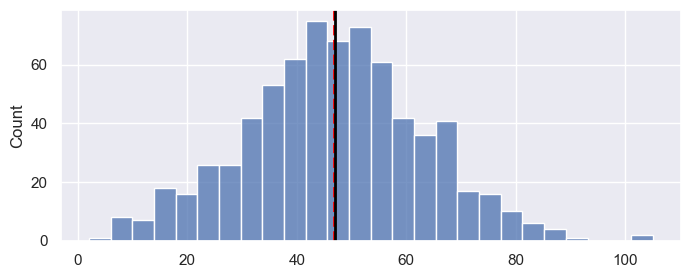

In [20]:
# Plot per-document token length distribution
transcript_lengths_array = np.asarray(transcripts_bow_tuple[0].sum(axis=1)).ravel()
plot_transcript_len(pd.Series(transcript_lengths_array))

In [21]:
# Create DF from BoW matrix and feature names
df_token_frequency = create_token_frequency(transcripts_bow_tuple)
df_token_frequency.head(15)

,token,total_frequency,doc_frequency,total_rank,doc_rank
0,like,2050,565,1,1
1,know,954,462,2,2
2,I,701,368,3,3
3,right,447,285,4,4
4,think,343,234,5,5
5,people,327,217,6,6
6,yeah,325,212,7,7
7,come,248,193,10,8
8,want,292,184,8,9
9,thing,222,178,14,10


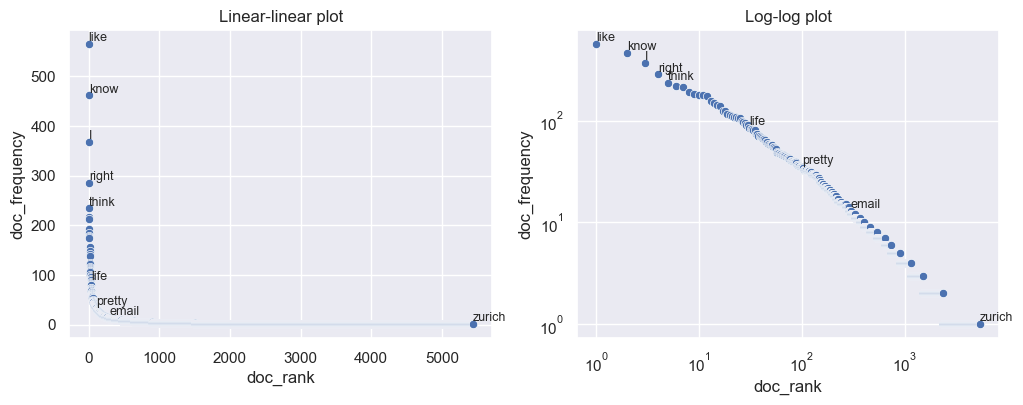

In [22]:
plot_zipf(df_token_frequency, rank_by='doc', top_n=5, bottom_n=1, mid_ranks = [30, 100, 300])

### Step 4: Remove very rare (min_df) and very common words (max_df)
Avoid unneeded noise for topic modeling.
- Set the `min_df` "cut-off" to a minimum of 2: tokens appearing in only 1 document are removed.
- Set the `max_df` to 10%: tokens appearing in more than 10% of documents are removed. **← from LiDA analysis**

In [23]:
%%time
features_dict = {
    'max_features': None, #default: None
    'max_df': 0.1, #default: 1.0 (float)
    'min_df': 2 #default: 1 (int)
}
# Call using features_dict (min_df)
transcripts_bow_tuple = vectorize_transcripts_to_bow(transcripts=df_transcripts_clean2['transcript'],
                                                     custom_preprocessor=custom_preprocessor_transcripts,
                                                     custom_tokenizer=custom_tokenizer_spacy_lemma,
                                                     stop_words=all_stop_words,
                                                     features_dict=features_dict
                                                    )
vocab_size.append({'CountVectorizer': 'Set min_df and max_df', 'vocab_size': len(transcripts_bow_tuple[1])})
np.savetxt('data/tokens5.txt', transcripts_bow_tuple[1], fmt='%s')

/opt/anaconda3/envs/NLP_E1282/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/NLP_E1282/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'll', 'regard', 'use', 've'] not in stop_words.
  warnings.warn(


CPU times: user 4min 35s, sys: 7.43 s, total: 4min 43s
Wall time: 4min 44s


In [24]:
# Print collected iterations of vocabulary size
pd.DataFrame(vocab_size)

,CountVectorizer,vocab_size
0,Use lemmatized tokens,5440
1,Set min_df and max_df,2312


The document token length mean is: 27.47


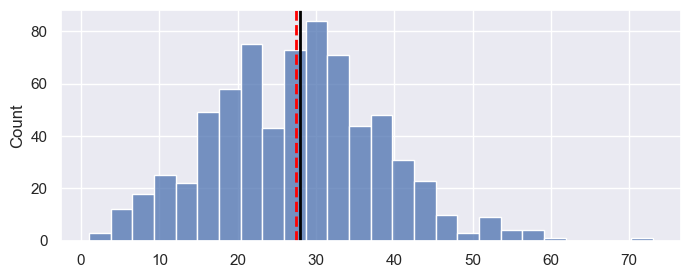

In [25]:
# Plot per-document token length distribution AFTER setting min_df
transcript_lengths_array = np.asarray(transcripts_bow_tuple[0].sum(axis=1)).ravel()
print(f'The document token length mean is: {transcript_lengths_array.mean():.2f}')
plot_transcript_len(pd.Series(transcript_lengths_array))

In [26]:
# Check BoW matrix size before LDiA
transcripts_bow_tuple[0]

<711x2312 sparse matrix of type '<class 'numpy.int64'>'
	with 15283 stored elements in Compressed Sparse Row format>

## Topic Modeling using Latent Dirichlet Allocation (LDiA)
- Code referenced from Lab 7 s7-basic-models-ii_challenge.ipynb and Raschka (YEAR).

In [27]:
%%time
# SET initial number of topics
k_topics=8
# Instantiate and fit LDiA model on document-term BoW using default settings
lda_doc_topics, lda_topic_words = fit_ldia_model(bow_csr=transcripts_bow_tuple[0],
                                                 k_topics=k_topics,
                                                 random_state=123
                                                )
lda_topic_words_norm = lda_topic_words / lda_topic_words.sum(axis=1)[:, None]
lda_doc_topics.shape

CPU times: user 600 ms, sys: 4.47 ms, total: 605 ms
Wall time: 609 ms


(711, 8)

### Analysis 1: Try to interpret topics from per-topic list of top words

In [28]:
# Create list of per-topic DataFrames for top words and their scores
n_top_words = 30
df_topic_words_list = create_df_topic_words_list(n_top_words=n_top_words,
                                                 topic_word_scores=lda_topic_words_norm,
                                                 word_names=transcripts_bow_tuple[1]
                                                )
# Print lists of top words for INTERPRETATION of topics
print_topic_words(df_topic_words_list)

Topic 1:
face friend white problem water cat close person game weed brunch high actually new straight french meet hate lose cool football old sport kind favorite black dude boy real ocean
Topic 2:
mom check walk actually class foot yes touch home big thank white middle comedy buy kid fish yellow box hear old hand hate night end watch sister spell indian cyan
Topic 3:
gay old date walk watch house new white actually play thank kind change real muslim fine pretty live bless happy bad stop night sexy marry girl understand problem turn kid
Topic 4:
baby happen ask car bad mom watch black white everybody bit old yes boy die room week sure face home live racist run kid job world big sort great dance
Topic 5:
party great eat plan bad food friend sex turn fun big run sexy play black break cool date bear girl kid long house sign watch chicken hard free shot susan
Topic 6:
friend sound white hate new find send walk book turn old stop bill hear night sex word black yes room long brain phone real 

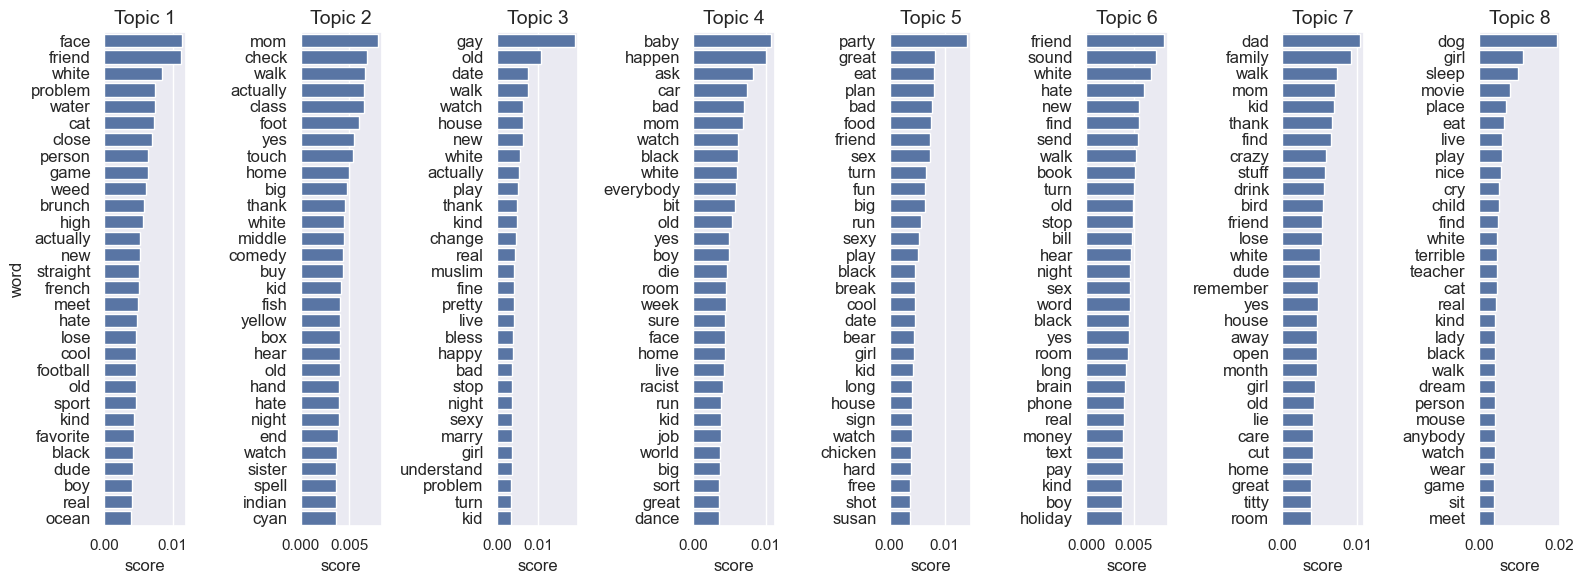

In [29]:
# Plot lists of top words for INTERPRETATION of topics
plot_topic_words(df_topic_words_list)

### Anaylsis 2: Check distribution of dominant topics per-document

In [30]:
# Check DISTRIBUTION of dominant topics
print_dominant_topics(lda_doc_topics)

dominant_topic
topic_2           119
topic_3            97
topic_5            95
topic_6            93
topic_4            84
topic_1            83
topic_0            82
topic_7            58
Name: count, dtype: int64
